In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
df_sentiments = pd.read_parquet("./data/ecb_press_sentiment.parquet")

In [3]:
df = df_sentiments[df_sentiments["global_sentiment_score"].isna()==0]

In [4]:
# Définir les tickers par secteur
secteurs = {
    "Banks": "EXH1.DE",        # iShares STOXX Europe 600 Banks
    "Oil & Gas": "EXH2.DE",    # iShares STOXX Europe 600 Oil & Gas
    "Technology": "EXH4.DE",   # iShares STOXX Europe 600 Technology
    "Healthcare": "EXH3.DE",   # iShares STOXX Europe 600 Health Care
    "Utilities": "EXH5.DE"     # iShares STOXX Europe 600 Utilities
}

# Définir la période et l'intervalle pour les données
periode = "10y"      # 1 an
intervalle = "5d"   # Quotidien

# Télécharger les données pour chaque secteur
data_secteurs = {}
for secteur, ticker in secteurs.items():
    print(f"Téléchargement des données pour le secteur : {secteur} ({ticker})")
    indice = yf.Ticker(ticker)
    data = indice.history(period=periode, interval=intervalle)
    data['Secteur'] = secteur
    data_secteurs[secteur] = data

print("\nTéléchargement terminé.")

Téléchargement des données pour le secteur : Banks (EXH1.DE)


Téléchargement des données pour le secteur : Oil & Gas (EXH2.DE)
Téléchargement des données pour le secteur : Technology (EXH4.DE)
Téléchargement des données pour le secteur : Healthcare (EXH3.DE)
Téléchargement des données pour le secteur : Utilities (EXH5.DE)

Téléchargement terminé.


In [5]:
df["Banks_sentiment_score"]

date
2024-12-12    0.5
2024-12-12    0.7
2024-12-12    0.7
2024-12-12    0.7
2024-12-12    0.7
             ... 
2005-10-17    0.8
2005-10-07    0.7
2005-10-07    0.7
2005-09-30    0.7
2005-09-30    0.4
Name: Banks_sentiment_score, Length: 1910, dtype: float64

In [6]:
for secteur, ticker in secteurs.items():
    df[f"{secteur}_score"] =  df[f"{secteur}_sentiment_score"]* df[f"{secteur}_relevance_score"]

/tmp/ipykernel_1920/2191212668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{secteur}_score"] =  df[f"{secteur}_sentiment_score"]* df[f"{secteur}_relevance_score"]
/tmp/ipykernel_1920/2191212668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{secteur}_score"] =  df[f"{secteur}_sentiment_score"]* df[f"{secteur}_relevance_score"]
/tmp/ipykernel_1920/2191212668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [7]:
for secteur, ticker in secteurs.items():
    print(df[f"{secteur}_relevance_score"].value_counts())

Banks_relevance_score
1.0    1899
0.0      10
0.5       1
Name: count, dtype: int64
Oil & Gas_relevance_score
0.0    1464
0.5     366
1.0      80
Name: count, dtype: int64
Technology_relevance_score
0.5    1041
0.0     677
1.0     192
Name: count, dtype: int64
Healthcare_relevance_score
0.0    1644
0.5     265
1.0       1
Name: count, dtype: int64
Utilities_relevance_score
0.0    1484
0.5     385
1.0      41
Name: count, dtype: int64


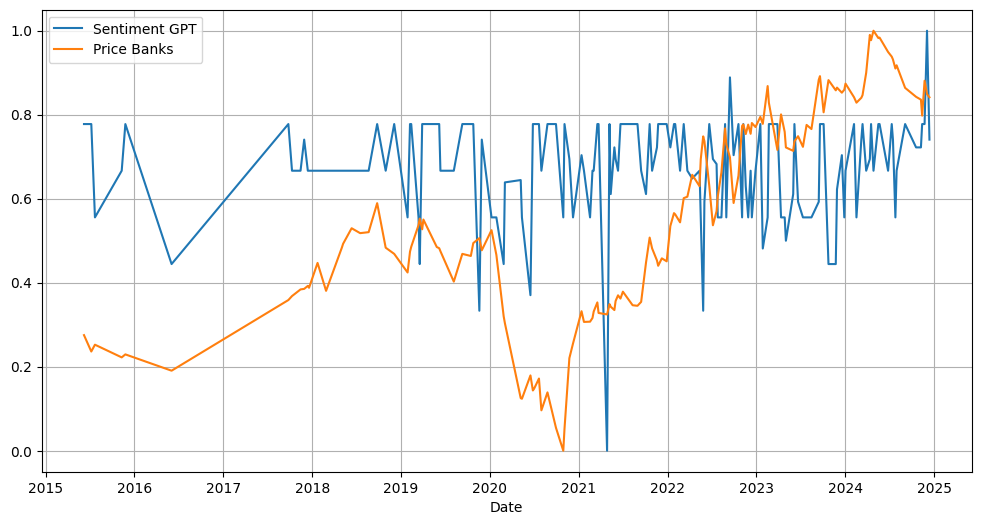

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sentiment_and_close(df, data, sector, agg_func='mean', shift=0):
    """
    Trace les valeurs de df["df_column"] par jour (avec min, max ou moyenne)
    et les valeurs de data[sector]["df_banks_column"] aux mêmes dates.

    :param df: DataFrame principal avec la colonne de sentiment
    :param data: Dictionnaire contenant les DataFrames des secteurs
    :param sector: Secteur spécifique pour extraire les données dans data
    :param df_column: Nom de la colonne de df à tracer
    :param df_banks_column: Nom de la colonne de df_banks à tracer
    :param agg_func: Fonction d'agrégation ('min', 'max', 'mean') pour les valeurs multiples par jour
    :param shift: Décalage des valeurs de df (en jours)
    """

    df_banks = data[sector]
    df_column = f"{sector}_score"
    df_banks_column = "Close"

    df.index = pd.to_datetime(df.index)
    df_banks.index = pd.to_datetime(df_banks.index)

    # Appliquer le décalage si nécessaire
    if shift != 0:
        df = df.copy()
        df[df_column] = df[df_column].shift(shift)

    # Grouper les données par date et appliquer l'agrégation choisie
    if agg_func == 'min':
        df_grouped = df.groupby(df.index.date)[df_column].min()
    elif agg_func == 'max':
        df_grouped = df.groupby(df.index.date)[df_column].max()
    elif agg_func == 'mean':
        df_grouped = df.groupby(df.index.date)[df_column].mean()
    else:
        raise ValueError("agg_func doit être 'min', 'max' ou 'mean'")

    # Regrouper les données de df_banks
    df_banks_grouped = df_banks.groupby(df_banks.index.date)[df_banks_column].mean()

    # Fusionner les deux DataFrames sur les dates communes
    merged_df = pd.DataFrame({
        'Sentiment': df_grouped,
        'Close': df_banks_grouped
    }).dropna()

    # Normaliser les données pour une meilleure comparabilité
    merged_df['Sentiment'] = (merged_df['Sentiment'] - merged_df['Sentiment'].min()) / (merged_df['Sentiment'].max() - merged_df['Sentiment'].min())
    merged_df['Close'] = (merged_df['Close'] - merged_df['Close'].min()) / (merged_df['Close'].max() - merged_df['Close'].min())

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(merged_df.index, merged_df['Sentiment'], label='Sentiment GPT')
    plt.plot(merged_df.index, merged_df['Close'], label=f'Price {sector}')
    plt.title('')
    plt.xlabel('Date')
    plt.ylabel('')
    plt.legend()
    plt.grid(True)
    plt.show()


sector = "Banks"
plot_sentiment_and_close(df, data_secteurs, sector, agg_func='mean', shift=2)

/tmp/ipykernel_1920/4141734293.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position = cash / self.prices[i]
/tmp/ipykernel_1920/4141734293.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.trades.append(('buy', i, self.prices[i]))
/tmp/ipykernel_1920/4141734293.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_value = cash + position * self.prices[i]
/tmp/ipykernel_1920/4141734293.py:37: FutureWarning: Seri

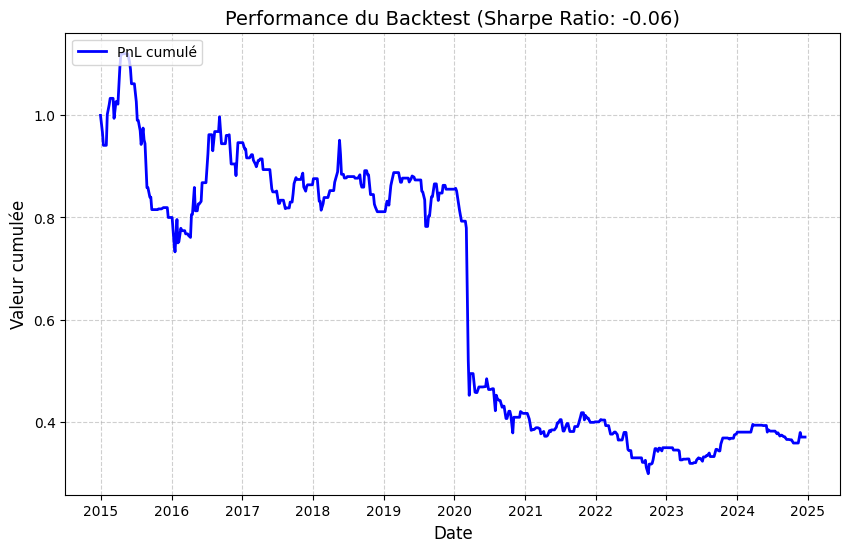

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Backtest:
    def __init__(self, prices, indicators, strategy_function):
        """
        Initialise le backtest.
        
        :param prices: pd.Series contenant les prix avec un index de type DateTimeIndex.
        :param indicators: np.array ou pd.Series contenant les indications.
        :param strategy_function: fonction qui renvoie 'buy', 'sell', ou 'hold'.
        """
        self.prices = prices
        self.indicators = np.array(indicators)
        self.strategy_function = strategy_function
        self.trades = []
        self.positions = []
        self.equity_curve = []

    def run(self, cash=1.0):
        """
        Exécute le backtest.
        """
        position = 0
        self.equity_curve = [cash]

        for i in range(len(self.prices)):
            signal = self.strategy_function(self.indicators[i])

            if signal == 'buy' and cash > 0:
                position = cash / self.prices[i]
                cash = 0
                self.trades.append(('buy', i, self.prices[i]))

            elif signal == 'sell' and position > 0:
                cash = position * self.prices[i]
                position = 0
                self.trades.append(('sell', i, self.prices[i]))

            total_value = cash + position * self.prices[i]
            self.equity_curve.append(total_value)
            self.positions.append(position)

    def evaluate(self):

        returns = np.diff(self.equity_curve) / self.equity_curve[:-1]
        total_return = (self.equity_curve[-1] / self.equity_curve[0]) - 1
        max_drawdown = self._max_drawdown()
        sharpe_ratio = np.mean(returns) / np.std(returns) if np.std(returns) > 0 else 0

        self.results = {
            "Total Return": total_return,
            "Max Drawdown": max_drawdown,
            "Sharpe Ratio": sharpe_ratio,
            "Trades": self.trades
                }
        return self.results

    def _max_drawdown(self):

        peak = -np.inf
        drawdown = 0
        for value in self.equity_curve:
            peak = max(peak, value)
            drawdown = max(drawdown, peak - value)
        return drawdown / peak if peak > 0 else 0

    def plot_backtest_results(self):
        """
        Trace la courbe de PnL cumulé et affiche le Sharpe Ratio.
        """
        plt.figure(figsize=(10, 6))

        plt.plot(self.prices.index, self.equity_curve[1:], label="PnL cumulé", color='blue', linewidth=2)

        plt.title(f"Performance du Backtest (Sharpe Ratio: {self.results['Sharpe Ratio']:.2f})", fontsize=14)

        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Valeur cumulée", fontsize=12)

        plt.legend(loc="upper left", fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.6)

        plt.show()

def simple_strategy(indicator_value):

    if indicator_value > 0:
        return 'buy'
    elif indicator_value < 0:
        return 'sell'
    else:
        return 'hold'

prices = data_secteurs["Banks"].Close
indicators = np.random.randn(len(prices))

bt = Backtest(prices, indicators, simple_strategy)
bt.run(cash=1)
results = bt.evaluate()

bt.plot_backtest_results()


In [ ]:
import pandas as pd
import numpy as np


def compute_sector_stats(df, df_sector, column_name, historic):
    """
    Calcule les statistiques (moyenne, min, max) sur les valeurs de la colonne spécifiée
    de df pour les derniers 'historic' jours avant chaque date de df_sector.

    Parameters:
    - df : DataFrame principal contenant les données à analyser.
    - df_sector : DataFrame contenant les valeurs historiques du secteur.
    - column_name : nom de la colonne dans df sur laquelle effectuer les calculs.
    - historic : nombre de jours à considérer pour le calcul.

    Returns:
    - Un DataFrame avec trois colonnes : 'mean', 'min', 'max' pour chaque ligne de df_sector.
    """
    
    # S'assurer que les dates sont tz-naive (si elles sont tz-aware)
    df.index = df.index.tz_localize(None)
    df_sector.index = df_sector.index.tz_localize(None)

    result_mean = []
    result_min = []
    result_max = []

    # Boucle sur chaque ligne de df_sector
    for date in df_sector.index:
        # Calculer la date de début de la période historique (sans inclure la date du jour même)
        start_date = date - pd.Timedelta(days=historic)

        sector_data = df[(df.index > start_date) & (df.index < date)]  # Exclure le jour même

        if not sector_data.empty:

            mean_value = sector_data[column_name].mean()
            min_value = sector_data[column_name].min()
            max_value = sector_data[column_name].max()
        else:
            mean_value = min_value = max_value = None  # Si aucune donnée n'est trouvée pour cette période
        
        result_mean.append(mean_value)
        result_min.append(min_value)
        result_max.append(max_value)

    stats_df = pd.DataFrame({
        'mean': result_mean,
        'min': result_min,
        'max': result_max
    }, index=df_sector.index)

    return stats_df


# Exemple d'utilisation
result_series = compute_sector_stats(df, data_secteurs["Banks"], "Banks_sentiment_score", 20)
print(result_series)


                mean  min  max
Date                          
2014-12-30       NaN  NaN  NaN
2015-01-09       NaN  NaN  NaN
2015-01-14       NaN  NaN  NaN
2015-01-19       NaN  NaN  NaN
2015-01-29       NaN  NaN  NaN
...              ...  ...  ...
2024-11-22  0.629412  0.3  0.7
2024-11-27  0.657143  0.5  0.7
2024-12-02  0.661538  0.5  0.7
2024-12-12  0.700000  0.6  0.9
2024-12-17  0.693750  0.5  0.9

[513 rows x 3 columns]


In [11]:
result_series = result_series.fillna("None")
result_series[result_series["min"]!= result_series["max"]]

,mean,min,max
Date,,,
2015-04-09,0.55,0.5,0.6
2015-06-03,0.72,0.6,0.8
2015-06-08,0.72,0.6,0.8
2015-06-18,0.742857,0.6,0.9
2015-06-23,0.75,0.7,0.9
...,...,...,...
2024-11-22,0.629412,0.3,0.7
2024-11-27,0.657143,0.5,0.7
2024-12-02,0.661538,0.5,0.7


In [12]:
data_secteurs.keys()

dict_keys(['Banks', 'Oil & Gas', 'Technology', 'Healthcare', 'Utilities'])

In [13]:
df["global_sentiment_score"]

date
2024-12-12    0.6
2024-12-12    0.6
2024-12-12    0.6
2024-12-12    0.8
2024-12-12    0.6
             ... 
2005-10-17    0.7
2005-10-07    0.6
2005-10-07    0.6
2005-09-30    0.8
2005-09-30    0.8
Name: global_sentiment_score, Length: 1910, dtype: float64

In [14]:
result_series

,mean,min,max
Date,,,
2014-12-30,None,None,None
2015-01-09,None,None,None
2015-01-14,None,None,None
2015-01-19,None,None,None
2015-01-29,None,None,None
...,...,...,...
2024-11-22,0.629412,0.3,0.7
2024-11-27,0.657143,0.5,0.7
2024-12-02,0.661538,0.5,0.7


/tmp/ipykernel_1920/4141734293.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position = cash / self.prices[i]
/tmp/ipykernel_1920/4141734293.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.trades.append(('buy', i, self.prices[i]))
/tmp/ipykernel_1920/4141734293.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_value = cash + position * self.prices[i]
/tmp/ipykernel_1920/4141734293.py:37: FutureWarning: Seri

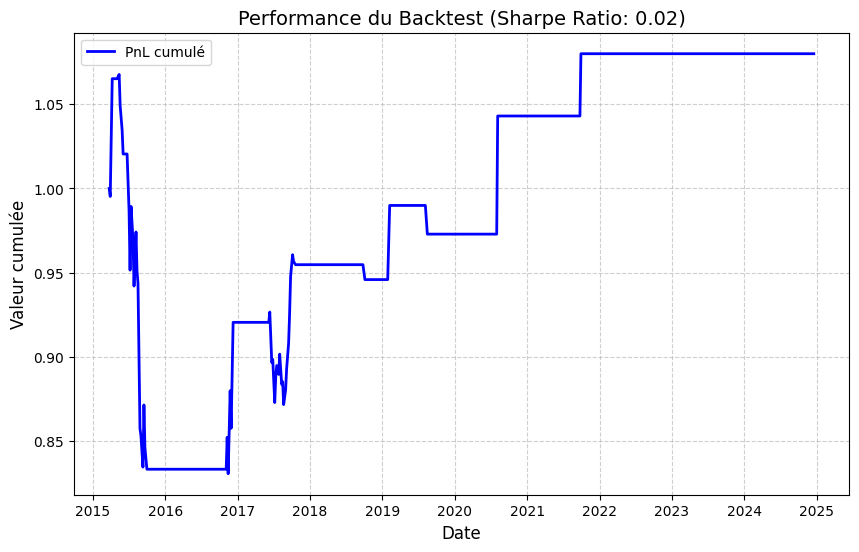

In [16]:
def strategy(indicator_value):
    """
    Exemple de stratégie simple.
    """

    if indicator_value[1] < 0.6:
        return 'sell'
    elif indicator_value[2] > 0.6:
        return 'buy'

    else:
        return 'hold'

result_series = compute_sector_stats(df, data_secteurs["Banks"], "global_sentiment_score", 10)

start = result_series.first_valid_index()
end = result_series.last_valid_index()
prices = data_secteurs["Banks"].Close.loc[start:end]
indicators = result_series.loc[start:end].to_numpy()


bt = Backtest(prices, indicators, strategy)
bt.run()
results = bt.evaluate()

bt.plot_backtest_results()